# Packet analysis with Scapy and NetworkX

This notebook accompanies Chapter 2, Project 1: Build a network graph from packets "<i>Programming Applied Mathematics for Security</i>". This material will cover additional analysis not presented in the book project for space reasons.

To follow along you must have the network_sim.pcap uncompressed in the same location as the notebook.

In [1]:
# -*- coding: utf-8 -*-
import networkx as nx
from matplotlib import pyplot as plt
import graph_funcs as hlp
from colour import Color

We load the file and organize it based off of MAC address of the NIC card. This allows for the possibility of machines changing I.P. addresses.

In [2]:
mdG = hlp.file_to_graph("network_sim.pcap") # MultiDiGraph
print("%d packets" % len(mdG.edges))
print("%d unique MACs" % len(mdG.nodes))

139873 packets
80 unique MACs


<p>Now we have a weighted, multi-edged, directed graph where each vertex is a machine and each edge is a packet which traveled from the source IP:Port to the destination IP:Port. We can examine all HTTP traffic across port 80 by getting a protocol subgraph. From the book's description we know that the protocol for node <i>u</i> is equal to the intersection of edges of the desired protocol, destined for the node in questione </p><p>HTTP = E (&psi;<sub>80</sub>) &cup; E(u &larr;)</p>

In [3]:
def protocol_subgraph(G, port):
    """Return a subgraph of G, filtered by the destination port"""
    proto_edges = [(u,v,d) for u,v,d in G.edges(data=True) if d["dport"] == port]
    if len(proto_edges) < 1:
        return None
    sub_graph = nx.DiGraph()
    sub_graph.add_edges_from(proto_edges)
    return sub_graph

dG = protocol_subgraph(mdG, 80)
out_deg = dG.out_degree(weight='weight')
sorted_deg = sorted(out_deg, key=lambda x: (x[1], x[0]), reverse=True)
print(sorted_deg[0])

('1c:6a:7a:0e:e0:41', 592)


In [4]:
psi = [80, 2503, 55553, 443]
for proto in psi:
    dG = protocol_subgraph(mdG, proto)
    out_deg = dG.out_degree(weight='weight')
    sorted_deg = sorted(out_deg, key=lambda x: (x[1], x[0]), reverse=True)
    print(proto, sorted_deg[0])

80 ('1c:6a:7a:0e:e0:41', 592)
2503 ('00:26:9e:3d:00:2a', 949)
55553 ('1c:6a:7a:0e:e0:41', 52)
443 ('00:0c:29:ac:42:4b', 678)


In [5]:
def label_set(G):
    """Create shortened label set (last 3 octets of MAC address)
    e.g. a1:b2:c3"""
    return {l:l[-8:] for l in G.nodes()}  # Dict Comprehension to create 
import numpy as np
from scipy import stats
protoG = protocol_subgraph(mdG, 80)
in_deg = protoG.in_degree(weight='weight')
in_deg= sorted(in_deg, key=lambda x: (x[1], x[0]))
scores = np.array([v[1] for v in in_deg])
z_thresh = stats.norm.ppf(0.95) # Confidence in denoting outliers
in_degree_z = stats.zscore(scores)
win_id = in_deg[in_degree_z.argmax()][0]
outlier_idx = list(np.where(in_degree_z > z_thresh)[0])
outlier_nodes = []
normal_nodes = []
for i in range(len(in_deg)):
    node_id = in_deg[i][0]
    if i in outlier_idx:
        outlier_nodes.append(node_id)
    else:
        normal_nodes.append(node_id)
nx.set_node_attributes(protoG, in_deg, "in_deg")

In [6]:
b = [in_deg[i][0] for i in range(len(in_deg)) if i in outlier_idx]
b

['7c:ad:74:c2:a9:a2', '1c:6a:7a:0e:e0:4e']

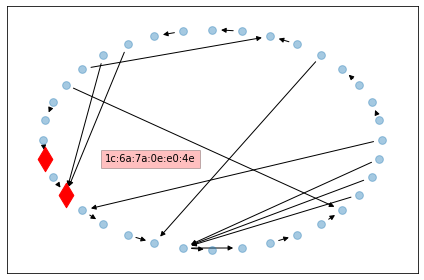

In [7]:
labels = label_set(protoG)
labels = {k : labels[k] if k in outlier_nodes else "" for k,v in list(in_deg)}
pos_dict = nx.shell_layout(protoG)
pos_dict

# create generator
norm_pos = {n:pos_dict[n] for n in normal_nodes}
outlier_pos = {n:pos_dict[n] for n in outlier_nodes}
#print(outlier_pos)

plt.text(outlier_pos[win_id][0]+0.5,outlier_pos[win_id][1]+0.3,s=win_id, bbox=dict(facecolor='red', alpha=0.25),horizontalalignment='center')
nx.draw_networkx_nodes(protoG, pos=norm_pos, nodelist=normal_nodes, node_size=60, alpha=0.4)
nx.draw_networkx_nodes(protoG, pos=outlier_pos, nodelist=outlier_nodes, node_shape='d', node_color='r')
nx.draw_networkx_edges(protoG, pos=pos_dict)
plt.tight_layout()
plt.savefig("Figure_4-4.svg", format="svg")
plt.savefig("Figure_4-4.png")

In [ ]:
print(outlier_nodes)

We can investigate which nodes have multiple IP addresses in the data sample. There are a number of reasons a MAC address may be assigned different I.P. addresses. One reason would be spoofing the source address for a packet. This is a common technique for attackers using a blind exploit. Another more innocent reason would be a machine which is logged off and then issued a new I.P. when it logs on. This would happen if the DHCP server released the I.P. to another machine which appeared in the interim.

In [ ]:
multi_ips = {}
for u in mdG.nodes.keys():
    ips_unique = []
    edges = mdG.out_edges(u, data=True)
    for u2,v,data in edges:
        if data["ip_src"] not in ips_unique:
            ips_unique.append(data["ip_src"])
    if len(ips_unique) > 1:
        #print(ips_unique[-5:])
        multi_ips[u] = ips_unique
for k in multi_ips.keys():
    print("%s had %d I.P.s" % (k, len(multi_ips[k])))
    


We can grab all the packets generated from a given MAC address by collecting all the outbound edges of the node associated with that MAC.

In [ ]:
edges = mdG.out_edges("1c:6a:7a:0e:e0:44", data=True)
sdG = nx.MultiDiGraph()
sdG.add_edges_from(edges)
pos = nx.shell_layout(sdG)

In [ ]:
fig = plt.figure(1, figsize=(12, 8), dpi=70)
nx.draw_networkx_nodes(sdG, pos, alpha=0.5)
nx.draw_networkx_edges(sdG, pos)
nx.draw_networkx_labels(sdG, pos)
plt.tight_layout()
plt.savefig("/home/dreilly/Desktop/Applied_Data_Science/Book_Resources/Chapter 4 - Network Graph/Figure_4-5.svg", format="svg")
plt.savefig("/home/dreilly/Desktop/Applied_Data_Science/Book_Resources/Chapter 4 - Network Graph/Figure_4-5.png")

# Information Exchange Ratio
The next two cell demonstrates the Information Exchange Ratio function from the book. The first simply returns the node with the highest IER score

In [ ]:
ier_scores = hlp.exchange_ratios(mdG)
u, score = ier_scores[-1] # Locates the highest overall
print(u, score)

The next cell finds outliers using a 99% confidence threshold and a one-tailed z-score test similar to before

In [ ]:
ier_scores = hlp.exchange_ratios(mdG)
z_thresh = round(stats.norm.ppf(0.99),3) # Confidence in denoting outliers
print(f"Using Standard Deviation threshold: {z_thresh}")
ier_z = stats.zscore([s[1] for s in ier_scores] )
outlier_idx = list(np.where(ier_z > z_thresh)[0]) # One tailed test
ier_outliers = [ier_scores[i] for i in outlier_idx]
print(ier_outliers)

# Saving and loading graphs
To save time on future analysis you can save the graph you've created using the write_weighted_edgelist function. This will create a file which retains the structure of the graph including the weight values for each edge.

In [ ]:
nx.write_weighted_edgelist(mdG, "sniff_out.edges")

You can reload the file into a graph using the inverse function read_weighted_edgelist on the previously created file. In this case we need to tell NetworkX to create the graph using the DiGraph class

In [ ]:
fileG = nx.read_weighted_edgelist("sniff_out.edges", create_using=nx.DiGraph)

You can then treat the loaded graph the same as before, calling any functions that would be valid on a DiGraph object

In [ ]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(protoG,'group').values())
mapping = dict(zip(sorted(groups),count()))
nodes = fileG.nodes()
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.shell_layout(fileG)
ec = nx.draw_networkx_edges(fileG, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(fileG, pos, nodelist=nodes, 
                            node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()


For more information on graph theory and how it applies to different types of network security analysis, check out the resources below:

"Handbook of graph theory" - JL Gross, J Yellen - CRC press 2004<br>
"Fast malware classification by automated behavioral graph matching" - Younghee Park et. al. IEEE, April 2010<br>
"Graph Theory and Cyber Security" -  Harith A. Dawood - IEEE April, 2015<br>
